In [1]:
# IMPORTS

# Learning Packages
import torch # pytorch
from torch import nn # pytorch neural networks
import torchvision
import torchvision.transforms as T # image transforms
import torchvision.models as models # pre-built models
import torch.nn.functional as F

import cv2 # opencv for image plotting

# Math
import numpy as np
import random

# Plotting
import matplotlib.pyplot as plt # plotting 
import seaborn as sns

# File Things
import os # file system access
import zipfile # unzipping dataset
from google.colab import drive # google drive 

#drive.mount('/content/drive')

In [2]:
#Import dataset from zip in google drive 

data_path = '/content/drive/MyDrive/classes/EE596_intro_to_DL/final_project/code/' # directory path
file_name = '140k_faces_kaggle_dataset.zip' # file name 

zip_ref = zipfile.ZipFile(data_path + file_name, 'r') # Open zip file in read mode
zip_ref.extractall('/tmp') # Extract files into /tmp folder
zip_ref.close() # cloze zip file 

In [3]:
# Dataset paths
train_path = '/tmp/real_vs_fake/real-vs-fake/train'
val_path = '/tmp/real_vs_fake/real-vs-fake/valid'
test_path = '/tmp/real_vs_fake/real-vs-fake/test'

imgNetMean = [0.485, 0.456, 0.406]
imgNetSTD = [0.229, 0.224, 0.225]

# Define Img Transform 
imgTransform = T.Compose([T.ToTensor(), 
                          T.Resize(size=(224,224)), 
                          T.Normalize(mean = imgNetMean, std = imgNetSTD)])

invImgTransform = T.Compose([T.Normalize(mean=[-m/s for m, s in zip(imgNetMean, imgNetSTD)], std = [1/s for s in imgNetSTD])])

# Define datasets 
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=imgTransform)
val_data = torchvision.datasets.ImageFolder(root=val_path, transform=imgTransform)
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=imgTransform)

# Batch sizes
train_batch_size = 64 
val_batch_size = 100
test_batch_size  = 100 

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=val_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=test_batch_size, shuffle=True)

#### Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


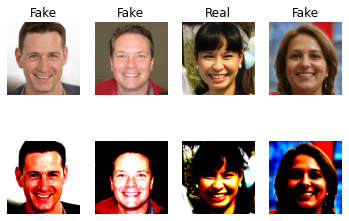

In [4]:
sample_data, sample_labels = iter(train_loader).next()

plt.figure()

for i in range(4):
  img = sample_data[i].numpy()
  original_img = invImgTransform(sample_data[i]).numpy()
  label = sample_labels[i].item()

  img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
  original_img = np.moveaxis(original_img, [0, 1, 2], [2, 0, 1])
  
  if label == 1:
    plt_label = 'Real'
  else:
    plt_label = 'Fake'

  plt.subplot(2,4,i + 1);
  plt.imshow(original_img);
  plt.title(plt_label);
  plt.axis('off');

  plt.subplot(2,4,i + 5);
  plt.imshow(img);
  plt.axis('off');

In [11]:
# Attach GPU

print(torch.cuda.device_count()) # number of GPUS attached 
print(torch.cuda.get_device_name(0)) # information about attached GPU

cuda0 = torch.device('cuda:0')

1
Tesla V100-SXM2-16GB


In [12]:
# Import and Edit DENSENET 121 Network
model = models.densenet121(pretrained=False)
for param in model.parameters(): # freeze the layers
   #param.requires_grad = False
   param.requires_grad = True

# Edit final Layer
number_features = model.classifier.in_features # Get number of inputs into final layer

# Use with Cross Entropy Loss
features = list(model.classifier.children())[:-1] # Remove last layer

#2
features.extend([nn.Linear(number_features, int(number_features/2)), nn.ReLU(), nn.Dropout(), nn.Linear(int(number_features/2), 2)])
model.classifier = nn.Sequential(*features) # Replace existing classifier

# Load Model
MODEL_PATH = '/content/drive/MyDrive/classes/EE596_intro_to_DL/final_project/code/densenet121model5.pth' # path to save model
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# move model to GPU
model = model.to(cuda0) # move model to GPU

print('Model Architecture')
print(model)

Model Architecture
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [13]:
#Calculate loss on test set - After all training done
total_test_count = 0 # total number of test inputs
total_test_correct = 0 # total correct classifications

confusion_matrix = np.zeros((2,2))

for test_sample in test_loader: # iterate through batches in test_loader
    x_test = test_sample[0]
    y_test = test_sample[1]
    x_test, y_test = x_test.to(cuda0), y_test.to(cuda0) # send inputs and labels to GPU
    
    with torch.no_grad(): # no weight adjustment 
        pred_probs = model(x_test) # calculate labels for test input batch
    
    _, y_test_pred = torch.max(pred_probs, 1)
    test_correct = torch.sum(y_test_pred == y_test)
    total_test_correct += test_correct.item()
    total_test_count += y_test.size()[0]

    for i in range(test_batch_size):
        confusion_matrix[y_test[i].int(), y_test_pred[i].int()] += 1
    
# Test Accuracy
print('Test Accuracy:', total_test_correct/total_test_count)

Test Accuracy: 0.97865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


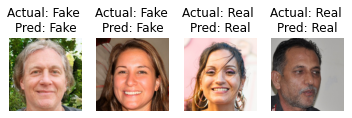

In [20]:
# Showing Real Images vs Predictions

rand_num = random.randrange(0, 100)

test_sample, test_sample_labels = iter(test_loader).next() # load in test sample

plt.figure() # create figure

for i in range(4): # iterate through first 4 images
  img = test_sample[i].numpy()
  original_img = invImgTransform(test_sample[i]).numpy()
  label = test_sample_labels[i].item()

  img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
  original_img = np.moveaxis(original_img, [0, 1, 2], [2, 0, 1])
  
  if label == 1:
    actual_label = 'Actual: Real \n'
  else:
    actual_label = 'Actual: Fake \n'

  test_sample_x = test_sample[i]
  test_sample_x = torch.unsqueeze(test_sample_x, dim=0)
  test_label_y = test_sample_labels[i]
  test_sample_x, test_label_y = test_sample_x.to(cuda0), test_label_y.to(cuda0) # send inputs and labels to GPU
    
  with torch.no_grad(): # no weight adjustment 
      pred_probs = model(test_sample_x) # calculate labels for test input batch
  
  _, y_test_pred = torch.max(pred_probs, 1)

  if y_test_pred == 1:
    pred_label = 'Pred: Real'
  else:
    pred_label = 'Pred: Fake'

  plt_label = actual_label + pred_label
  

  plt.subplot(1,4,i + 1);
  plt.imshow(original_img);
  plt.title(plt_label);
  plt.axis('off');

#### Confusion Matrix

[[9867.  133.]
 [ 294. 9706.]]


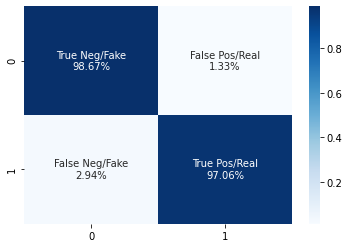

In [21]:
# Confusion Matrix 
print(confusion_matrix)

total_vals = np.sum(confusion_matrix)
confusion_matrix = confusion_matrix / total_vals * 2

group_names = ['True Neg/Fake','False Pos/Real','False Neg/Fake','True Pos/Real']
group_percentages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confusion_matrix, annot=labels, fmt='',cmap='Blues')

#### Saliency Map

In [23]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """

    # Make sure the model is in "test" mode
    X, y = X.to(cuda0), y.to(cuda0)
    model = model.to(cuda0)
    model.eval()

    # Make input tensor require gradient
    X.requires_grad_()

    saliency = None
    scores = model(X)
    scores = scores.gather(1, y.view(-1, 1)).squeeze()

    scores = scores.cpu()

    #backward pass
    scores.backward(torch.FloatTensor([1.0]*scores.shape[0]))

    #saliency
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)

    return saliency


def show_saliency_maps(X, y):
    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X, y, model)
    saliency = saliency.cpu()

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    X = X.numpy()
    X = np.moveaxis(X, [0,1,2,3], [0,3,1,2])

    class_names = ['Fake','Real']

    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


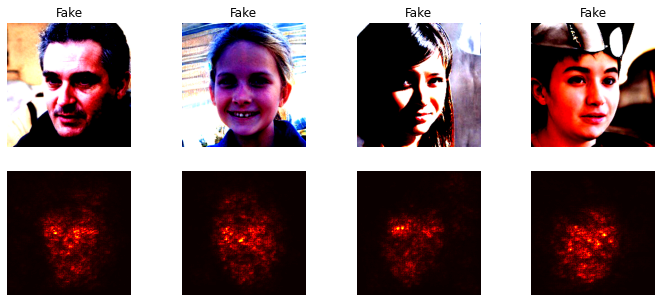

In [32]:
# Sample Test Images
sample_data, sample_labels = iter(test_loader).next()

imgs = sample_data[0:4]
labels = sample_labels[0:4]

show_saliency_maps(imgs, labels)